# Question No. 1:
### Theory and concepts:
<span style='color: red;'> 1. Explain the concept of batch normalization in the context of Artificial Neural Networks. </span>
>Batch Norm is a normalization technique done between the layers of a Neural Network instead of in the raw data. It is done along mini-batches instead of the full data set. It serves to speed up training and use higher learning rates, making learning easier.

<span style='color: red;'> 2. Describe the benefits of using batch normalization during training. </span>
>**Accelerated training:** Batch normalization reduces the internal covariate shift by normalizing the inputs to each layer. This helps in stabilizing and accelerating the training process, allowing the network to converge faster. With batch normalization, the learning algorithm can make larger updates to the model parameters, leading to faster overall training.<br>**Improved generalization:** By reducing the internal covariate shift, batch normalization acts as a regularizer, which helps in preventing overfitting. It reduces the reliance on specific weights or activations and encourages the network to learn more generalizable features. This can lead to better generalization performance, especially when dealing with limited training data.<br>**Mitigating the vanishing/exploding gradients problem:** Deep neural networks often suffer from the problem of vanishing or exploding gradients, especially in deeper layers. Batch normalization helps in alleviating this issue by keeping the activations within a desirable range. It normalizes the activations and ensures that the gradients flowing through the network are neither too large nor too small, thus improving the stability of the optimization process.<br>**Reducing the need for manual hyperparameter tuning:** Batch normalization reduces the dependence on certain hyperparameters, such as the learning rate, to achieve good performance. It makes the network more robust to different learning rates and allows for faster convergence. This reduces the need for extensive manual tuning, saving time and effort in the model development process.

3. Discuss the working principle of batch normalization, including the normalization step and the learnable parameters.
>In the following image, we can see a regular feed-forward Neural Network: x_i are the inputs, z the output of the neurons, a the output of the activation functions, and y the output of the network:
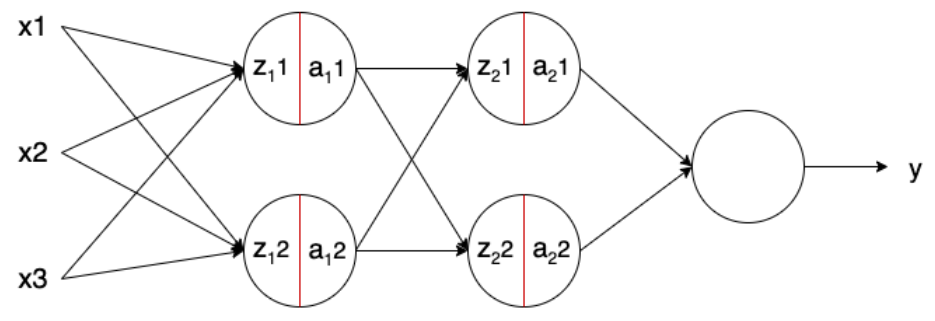<br><br>Batch Norm – in the image represented with a red line – is applied to the neurons’ output just before applying the activation function.Usually, a neuron without Batch Norm would be computed as follows:
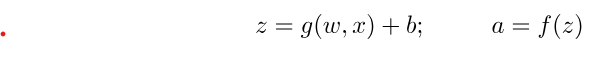<br><br>being g() the linear transformation of the neuron, w the weights of the neuron, b the bias of the neurons, and f() the activation function. The model learns the parameters w and b. Adding Batch Norm, it looks as:
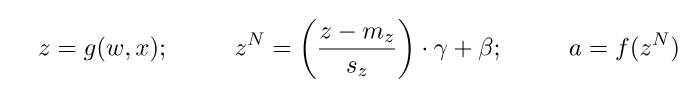<br><br>being z^N the output of Batch Norm, m_z the mean of the neurons’ output, s_z the standard deviation of the output of the neurons, and \gamma and \beta learning parameters of Batch Norm. Note that the bias of the neurons (b) is removed. This is because as we subtract the mean m_z, any constant over the values of z – such as b – can be ignored as it will be subtracted by itself.<br><br>**The parameters \beta and \gamma shift the mean and standard deviation, respectively. Thus, the outputs of Batch Norm over a layer results in a distribution with a mean \beta and a standard deviation of \gamma. These values are learned over epochs and the other learning parameters, such as the weights of the neurons, aiming to decrease the loss of the model.**

# Question No. 2:
### Implementation:
<span style='color: red;'> 1. Choose a dataset of your choice (e.g., MNIST, CIAR-0) and preprocess it.<br>
2. Implement a simple feedforward neural network using any deep learning framework/library (e.g.,Tensorlow, PyTorch).<br>
3. Train the neural network on the chosen dataset without using batch normalization. <span>

**Training model without Batch Normalization**

In [22]:
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import SGD

from sklearn.model_selection import KFold
from matplotlib import pyplot as plt
from numpy import mean, std

In [18]:
def load_dataset():
    """
    Load train and test dataset
    """
    (trainX, trainY),(testX, testY) = mnist.load_data()
    # reshape dataset to have a single channel for color
    trainX = trainX.reshape((trainX.shape[0], 28, 28, 1))
    testX = testX.reshape((testX.shape[0], 28, 28, 1))
    #one-hot encode target values
    trainY = to_categorical(trainY)
    testY = to_categorical(testY)
    return trainX, trainY, testX, testY

def prep_pixels(train, test):
    """
    Scale pixels
    """
    #convert from integers to floats
    train_norm = train.astype('float32')
    test_norm = test.astype('float32')
    #normalize to range 0-1
    train_norm = train_norm/255.0
    test_norm = test_norm/255.0
    return train_norm, test_norm

def define_model():
    """
    Define CNN model
    """
    model = Sequential()
    model.add(Conv2D(32, (3,3), activation='relu', kernel_initializer='he_uniform', input_shape=(28,28,1)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(10, activation='softmax'))
    #compile model
    opt = SGD(learning_rate=0.01, momentum=0.9)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

def evaluate_model(dataX, dataY, n_folds=5):
    """
    Evaluate the model using k-fold cross-validation
    """
    scores, histories = list(), list()
    # prepare cross validation
    kfold = KFold(n_folds, shuffle=True, random_state=1)
    # enumerate splits
    for train_ix, test_ix in kfold.split(dataX):
        # define model
        model = define_model()
        # select rows for train and test
        trainX, trainY, testX, testY = dataX[train_ix], dataY[train_ix], dataX[test_ix], dataY[test_ix]
        # fit model
        history = model.fit(trainX, trainY, epochs=10, batch_size=32, validation_data=(testX, testY), verbose=0)
        # evaluate model
        _, acc = model.evaluate(testX, testY, verbose=0)
        print('> %.3f' % (acc * 100.0))
        # stores scores
        scores.append(acc)
        histories.append(history)
    return scores, histories
 
def summarize_diagnostics(histories):
    """
    Plot diagnostic learning curves
    """
    for i in range(len(histories)):
    # plot loss
        plt.subplot(2, 1, 1)
        plt.title('Cross Entropy Loss')
        plt.plot(histories[i].history['loss'], color='blue', label='train')
        plt.plot(histories[i].history['val_loss'], color='orange', label='test')
        # plot accuracy
        plt.subplot(2, 1, 2)
        plt.title('Classification Accuracy')
        plt.plot(histories[i].history['accuracy'], color='blue', label='train')
        plt.plot(histories[i].history['val_accuracy'], color='orange', label='test')
    plt.show()
    
def summarize_performance(scores):
    """
    Summarize model performance
    """
    # print summary
    print('Accuracy: mean=%.3f std=%.3f, n=%d' % (mean(scores)*100, std(scores)*100, len(scores)))
    # box and whisker plots of results
    plt.boxplot(scores)
    plt.show()
    
def run_test_harness():
    """
    Run the test harness for evaluating a model
    """
    # load dataset
    trainX, trainY, testX, testY = load_dataset()
    # prepare pixel data
    trainX, testX = prep_pixels(trainX, testX)
    # evaluate model
    scores, histories = evaluate_model(trainX, trainY)
    # learning curves
    summarize_diagnostics(histories)
    # summarize estimated performance
    summarize_performance(scores)

> 98.625
> 98.700
> 98.617
> 98.825
> 98.750


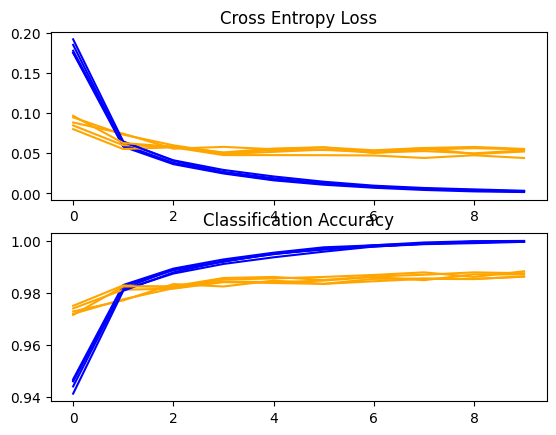

Accuracy: mean=98.703 std=0.078, n=5


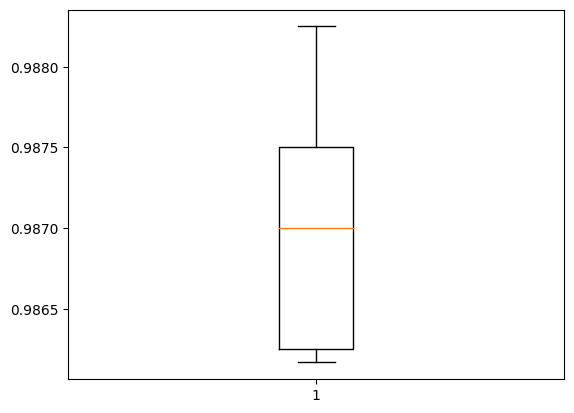

In [19]:
# entry point, run the test harness
run_test_harness()

<span style='color: red;'> 4. Implement batch normalization layers in the neural network and train the model again.<br> </span>
<span style='color: red;'> 5. Compare the training and validation performance (e.g., accuracy, loss) between the models with and without batch normalization. </span>

**Training model with Batch Normalization**<br>
We can just update the model definition to use batch normalization after the activation function for the convolutional and dense layers of our baseline model. The updated version of define_model() function with batch normalization is listed below

In [20]:
# define cnn model
def define_model():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(28, 28, 1)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
    model.add(BatchNormalization())
    model.add(Dense(10, activation='softmax'))
    # compile model
    opt = SGD(learning_rate=0.01, momentum=0.9)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

> 98.483
> 98.692
> 98.708
> 98.700
> 98.442


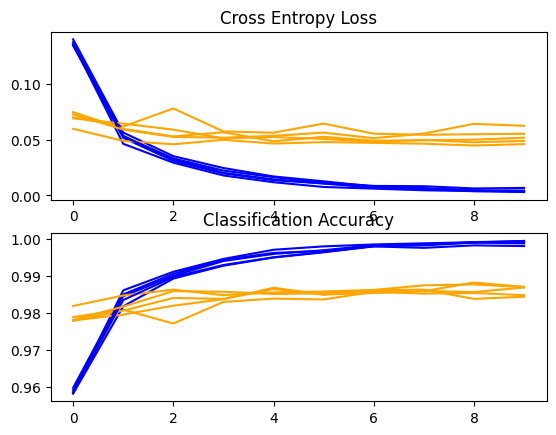

Accuracy: mean=98.605 std=0.117, n=5


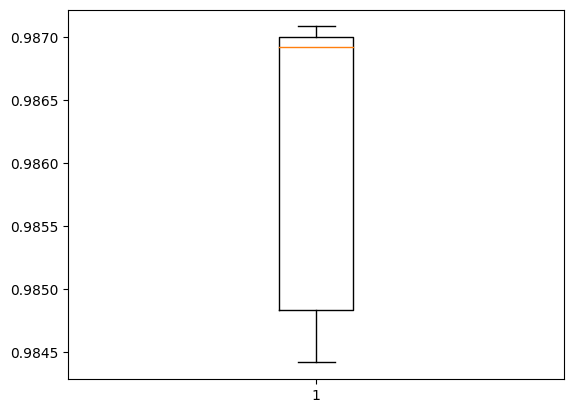

In [23]:
# entry point, run the test harness
run_test_harness()

<span style='color: red;'> 6. Discuss the impact of batch normalization on the training process and the performance of the neural network. </span>

- We can see perhaps a small drop in model performance as compared to the baseline across the cross-validation folds.

- The plots of the learning curves are created, in this case showing that the speed of learning (improvement over epochs) does not appear to be different from the baseline model.

- The plots suggest that batch normalization, at least as implemented in this case, does not offer any benefit.

- The estimated performance of the models is presented, showing performance with a slight decrease in the mean accuracy of the model with batch normalization: 98.605 as compared to 98.703 with the baseline model.

# Question No. 3:
### Experimentation and Analysis:

<span style='color: red;'> 1. Experiment with different batch sizes and observe the effect on the training dynamics and model performance.</span>

**For the following experiment; Batch Size = 20**

In [24]:
def load_dataset():
    """
    Load train and test dataset
    """
    (trainX, trainY),(testX, testY) = mnist.load_data()
    # reshape dataset to have a single channel for color
    trainX = trainX.reshape((trainX.shape[0], 28, 28, 1))
    testX = testX.reshape((testX.shape[0], 28, 28, 1))
    #one-hot encode target values
    trainY = to_categorical(trainY)
    testY = to_categorical(testY)
    return trainX, trainY, testX, testY

def prep_pixels(train, test):
    """
    Scale pixels
    """
    #convert from integers to floats
    train_norm = train.astype('float32')
    test_norm = test.astype('float32')
    #normalize to range 0-1
    train_norm = train_norm/255.0
    test_norm = test_norm/255.0
    return train_norm, test_norm


def define_model():
    """
    Define CNN model (with batch normalization)
    """
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(28, 28, 1)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
    model.add(BatchNormalization())
    model.add(Dense(10, activation='softmax'))
    # compile model
    opt = SGD(learning_rate=0.01, momentum=0.9)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

def evaluate_model(dataX, dataY, n_folds=5):
    """
    Evaluate the model using k-fold cross-validation
    """
    scores, histories = list(), list()
    # prepare cross validation
    kfold = KFold(n_folds, shuffle=True, random_state=1)
    # enumerate splits
    for train_ix, test_ix in kfold.split(dataX):
        # define model
        model = define_model()
        # select rows for train and test
        trainX, trainY, testX, testY = dataX[train_ix], dataY[train_ix], dataX[test_ix], dataY[test_ix]
        # fit model
        history = model.fit(trainX, trainY, epochs=10, batch_size=20, validation_data=(testX, testY), verbose=0)
        # evaluate model
        _, acc = model.evaluate(testX, testY, verbose=0)
        print('> %.3f' % (acc * 100.0))
        # stores scores
        scores.append(acc)
        histories.append(history)
    return scores, histories
 
def summarize_diagnostics(histories):
    """
    Plot diagnostic learning curves
    """
    for i in range(len(histories)):
    # plot loss
        plt.subplot(2, 1, 1)
        plt.title('Cross Entropy Loss')
        plt.plot(histories[i].history['loss'], color='blue', label='train')
        plt.plot(histories[i].history['val_loss'], color='orange', label='test')
        # plot accuracy
        plt.subplot(2, 1, 2)
        plt.title('Classification Accuracy')
        plt.plot(histories[i].history['accuracy'], color='blue', label='train')
        plt.plot(histories[i].history['val_accuracy'], color='orange', label='test')
    plt.show()
    
def summarize_performance(scores):
    """
    Summarize model performance
    """
    # print summary
    print('Accuracy: mean=%.3f std=%.3f, n=%d' % (mean(scores)*100, std(scores)*100, len(scores)))
    # box and whisker plots of results
    plt.boxplot(scores)
    plt.show()
    
def run_test_harness():
    """
    Run the test harness for evaluating a model
    """
    # load dataset
    trainX, trainY, testX, testY = load_dataset()
    # prepare pixel data
    trainX, testX = prep_pixels(trainX, testX)
    # evaluate model
    scores, histories = evaluate_model(trainX, trainY)
    # learning curves
    summarize_diagnostics(histories)
    # summarize estimated performance
    summarize_performance(scores)

> 98.433
> 98.592
> 98.233
> 98.517
> 98.758


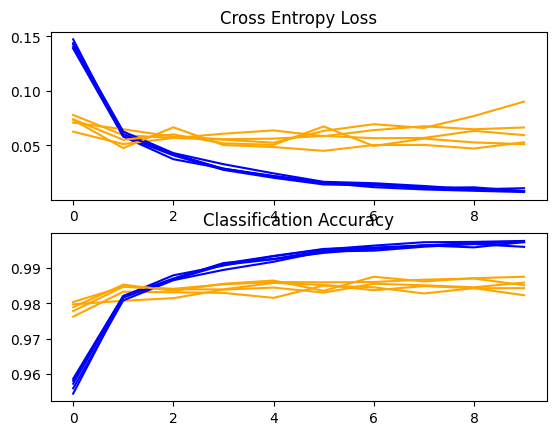

Accuracy: mean=98.507 std=0.174, n=5


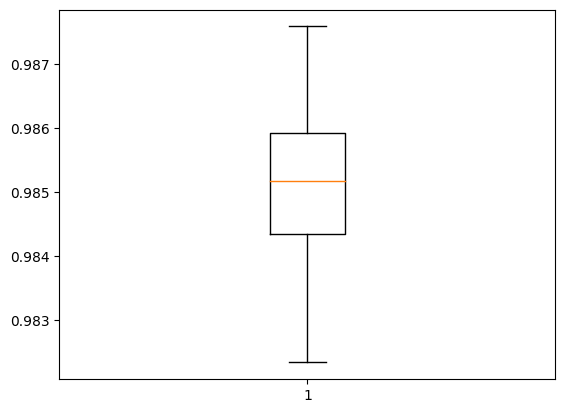

In [25]:
# entry point, run the test harness
run_test_harness()

**For the following experiment; Batch Size = 40**

In [26]:
def load_dataset():
    """
    Load train and test dataset
    """
    (trainX, trainY),(testX, testY) = mnist.load_data()
    # reshape dataset to have a single channel for color
    trainX = trainX.reshape((trainX.shape[0], 28, 28, 1))
    testX = testX.reshape((testX.shape[0], 28, 28, 1))
    #one-hot encode target values
    trainY = to_categorical(trainY)
    testY = to_categorical(testY)
    return trainX, trainY, testX, testY

def prep_pixels(train, test):
    """
    Scale pixels
    """
    #convert from integers to floats
    train_norm = train.astype('float32')
    test_norm = test.astype('float32')
    #normalize to range 0-1
    train_norm = train_norm/255.0
    test_norm = test_norm/255.0
    return train_norm, test_norm


def define_model():
    """
    Define CNN model (with batch normalization)
    """
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(28, 28, 1)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
    model.add(BatchNormalization())
    model.add(Dense(10, activation='softmax'))
    # compile model
    opt = SGD(learning_rate=0.01, momentum=0.9)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

def evaluate_model(dataX, dataY, n_folds=5):
    """
    Evaluate the model using k-fold cross-validation
    """
    scores, histories = list(), list()
    # prepare cross validation
    kfold = KFold(n_folds, shuffle=True, random_state=1)
    # enumerate splits
    for train_ix, test_ix in kfold.split(dataX):
        # define model
        model = define_model()
        # select rows for train and test
        trainX, trainY, testX, testY = dataX[train_ix], dataY[train_ix], dataX[test_ix], dataY[test_ix]
        # fit model
        history = model.fit(trainX, trainY, epochs=10, batch_size=40, validation_data=(testX, testY), verbose=0)
        # evaluate model
        _, acc = model.evaluate(testX, testY, verbose=0)
        print('> %.3f' % (acc * 100.0))
        # stores scores
        scores.append(acc)
        histories.append(history)
    return scores, histories
 
def summarize_diagnostics(histories):
    """
    Plot diagnostic learning curves
    """
    for i in range(len(histories)):
    # plot loss
        plt.subplot(2, 1, 1)
        plt.title('Cross Entropy Loss')
        plt.plot(histories[i].history['loss'], color='blue', label='train')
        plt.plot(histories[i].history['val_loss'], color='orange', label='test')
        # plot accuracy
        plt.subplot(2, 1, 2)
        plt.title('Classification Accuracy')
        plt.plot(histories[i].history['accuracy'], color='blue', label='train')
        plt.plot(histories[i].history['val_accuracy'], color='orange', label='test')
    plt.show()
    
def summarize_performance(scores):
    """
    Summarize model performance
    """
    # print summary
    print('Accuracy: mean=%.3f std=%.3f, n=%d' % (mean(scores)*100, std(scores)*100, len(scores)))
    # box and whisker plots of results
    plt.boxplot(scores)
    plt.show()
    
def run_test_harness():
    """
    Run the test harness for evaluating a model
    """
    # load dataset
    trainX, trainY, testX, testY = load_dataset()
    # prepare pixel data
    trainX, testX = prep_pixels(trainX, testX)
    # evaluate model
    scores, histories = evaluate_model(trainX, trainY)
    # learning curves
    summarize_diagnostics(histories)
    # summarize estimated performance
    summarize_performance(scores)

> 98.617
> 98.700
> 98.692
> 98.917
> 98.850


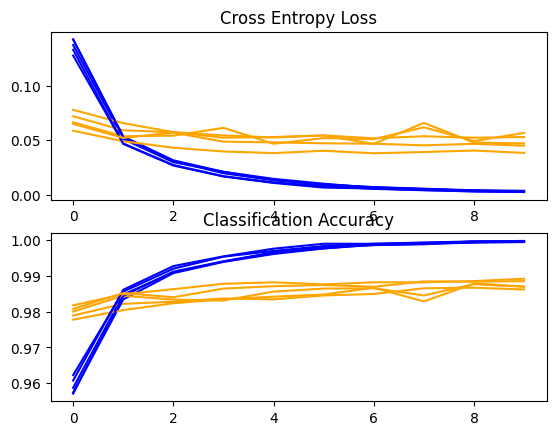

Accuracy: mean=98.755 std=0.111, n=5


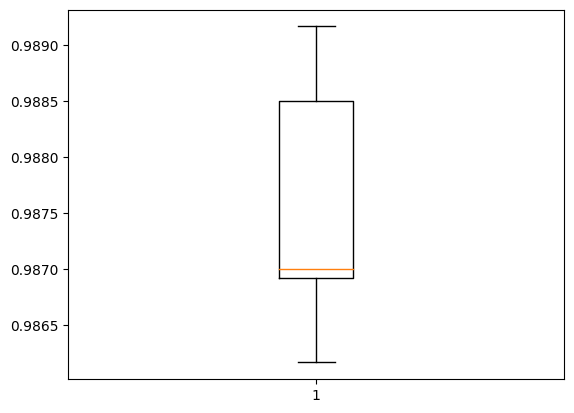

In [27]:
# entry point, run the test harness
run_test_harness()

**Analysis:**<br>
- Decreasing the batch size down to 20 resulted in lower accuracy scores.
- Increasing the batch size to 40 resulted the highest mean accuracy score: 98.775

=============================================================================================================

<span style='color: red;'> 2. Discuss the advantages and potential limitations of batch normalization in improving the training of neural networks.</span>

**Advantages of Batch Normalization:**

Accelerated convergence: Batch normalization helps neural networks converge faster by reducing the internal covariate shift. By normalizing the activations of each layer, it ensures that the mean activation is close to zero and the standard deviation is close to one. This allows for more stable and efficient gradient propagation, enabling faster convergence.

- **Improved generalization:** Batch normalization acts as a form of regularization by adding a small amount of noise to the network during training. This noise helps to reduce overfitting and improves the generalization ability of the model. It has been observed that models with batch normalization tend to generalize better to unseen data.

- **Reduction of the dependence on initialization:** Batch normalization reduces the sensitivity of neural networks to the choice of weight initialization. By normalizing the inputs to each layer, it mitigates the impact of initialization choices, making the network more robust to different initialization schemes.

- **Handling of different batch sizes:** Batch normalization is effective in handling different batch sizes during training. It normalizes the activations based on the statistics computed from the mini-batch, allowing flexibility in choosing the batch size without significantly affecting the performance of the model.

**Limitations of Batch Normalization:**

- **Dependency on batch size:** Although batch normalization handles different batch sizes, its performance can be affected by very small batch sizes. When the batch size is too small, the estimated statistics may become less reliable, leading to suboptimal performance. However, this limitation can be mitigated by techniques such as running mean and variance estimation or using larger batch sizes.

- **Increased memory consumption:** Batch normalization requires storing and updating running mean and variance statistics during training. This introduces additional memory overhead, especially when training large models or working with limited computational resources. However, the memory requirement can be reduced by utilizing optimized implementations and hardware accelerators.

- **Influence of batch order:** The order of samples within a batch can have an impact on the statistics used for normalization. This can introduce a small amount of variability during training and affect the final performance. However, this limitation is generally not significant and can be mitigated by shuffling the training data between epochs.

- **Incompatibility with certain network architectures:** Batch normalization may not work well with certain network architectures that have complex or dynamic internal dependencies. For example, networks that use recurrent connections or self-attention mechanisms may not benefit from batch normalization or require modifications to the technique to make it suitable for such architectures.